In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.tree
import graphviz
import pydotplus
from IPython.display import Image
from sklearn import datasets
from sklearn.base import BaseEstimator

# Применение решающего дерева

In [2]:
data = pd.read_csv('german.data', delimiter=' ', header=None)

In [3]:
data.columns = ["Account status", "Duration", "History", "Purpose",
             "Amount", "Savings", "Employment", "Rate", "Status / sex",
             "Debtors", "Residence", "Property", "Age", "Plans", 
             "Housing", "#credits", "Job", "#people to provide", "Telephone", "Foreign", "Target"]

In [4]:
data.head()

,Account status,Duration,History,Purpose,Amount,Savings,Employment,Rate,Status / sex,Debtors,...,Property,Age,Plans,Housing,#credits,Job,#people to provide,Telephone,Foreign,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


В датасете есть категориальные признаки, с которыми решающие деревья не работают. Поэтому перекодируем каждый категориальный признак в несколько бинарных.

In [5]:
data = pd.get_dummies(data, prefix=["Account_status", "History", "Purpose", "Savings",
                            "Employment", "Status / sex", "Debtors", "Property", 
                            "Plans", "Housing", "Job", "Telephone", "Foreign"])

In [6]:
data.head()

,Duration,Amount,Rate,Residence,Age,#credits,#people to provide,Target,Account_status_A11,Account_status_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,Foreign_A201,Foreign_A202
0,6,1169,4,4,67,2,1,1,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,48,5951,2,2,22,1,1,2,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,12,2096,2,3,49,1,2,1,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,42,7882,2,4,45,1,2,1,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,24,4870,3,4,53,2,2,2,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [7]:
X = data.drop("Target", 1)

In [8]:
y = data["Target"]

In [9]:
data.shape

(1000, 62)

In [10]:
clf = sklearn.tree.DecisionTreeRegressor(max_depth=15)
clf.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [11]:
dot_data = sklearn.tree.export_graphviz(clf, out_file="tree.out",
                         filled=True, rounded=True,  
                         special_characters=True)

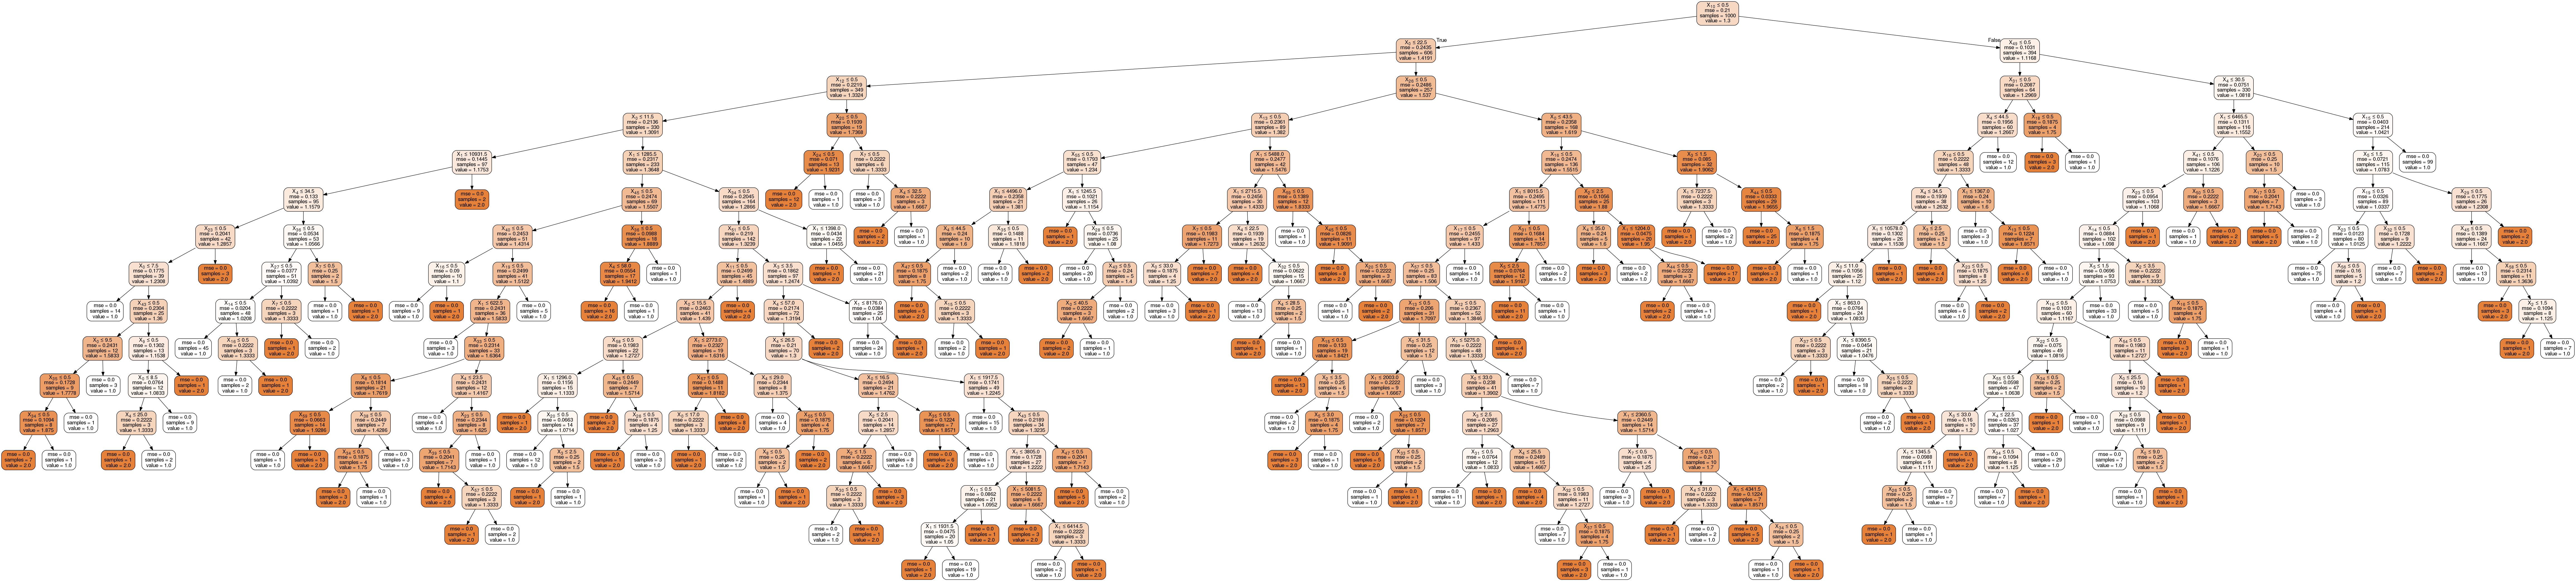

In [12]:
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")  
Image(graph.create_png())

In [13]:
X.columns[10]

'Account_status_A14'

In [14]:
X.columns[49]

'Plans_A143'

In [15]:
X.columns[0]

'Duration'

Посмотрим на первые разбиения. Вначале дерево разбивает объекты по признаку состояния аккаунта. Если у человека не было аккаунта, то его относят к группе с большей вероятностью невозвращения кредита, что логично. 

Далее, если у клиента есть кредитный аккаунт, то следующий рассматриваемый признак - наличие других кредитных обязательств. Если кредитных обязательств нет, то клиента можно с большей вероятностью отнести к группе людей, которые возвратят кредит.

Если у клиента нет аккаунта, алгоритм смотрит на длительность кредита. Если кредит краткосрочный, то его легче выплатить. 

Как видим, построение разбиений можно весьма логично интерпретировать

Теперь построим график зависимости качества на 5-FOLD кросс-валидации в зависимости от глубины.

In [16]:
def quality_cross_val(max_depth):
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    return sklearn.cross_validation.cross_val_score(clf, X, y, cv=5).mean()

In [17]:
def plot_quality(method):
    plt.figure(figsize=(15, 7))
    depths = np.arange(3, 50)
    qualities = list(map(lambda x: method(x), depths))
    plt.plot(depths, qualities)
    plt.xlabel("Depth")
    plt.ylabel("Cross-val-score")
    plt.show()

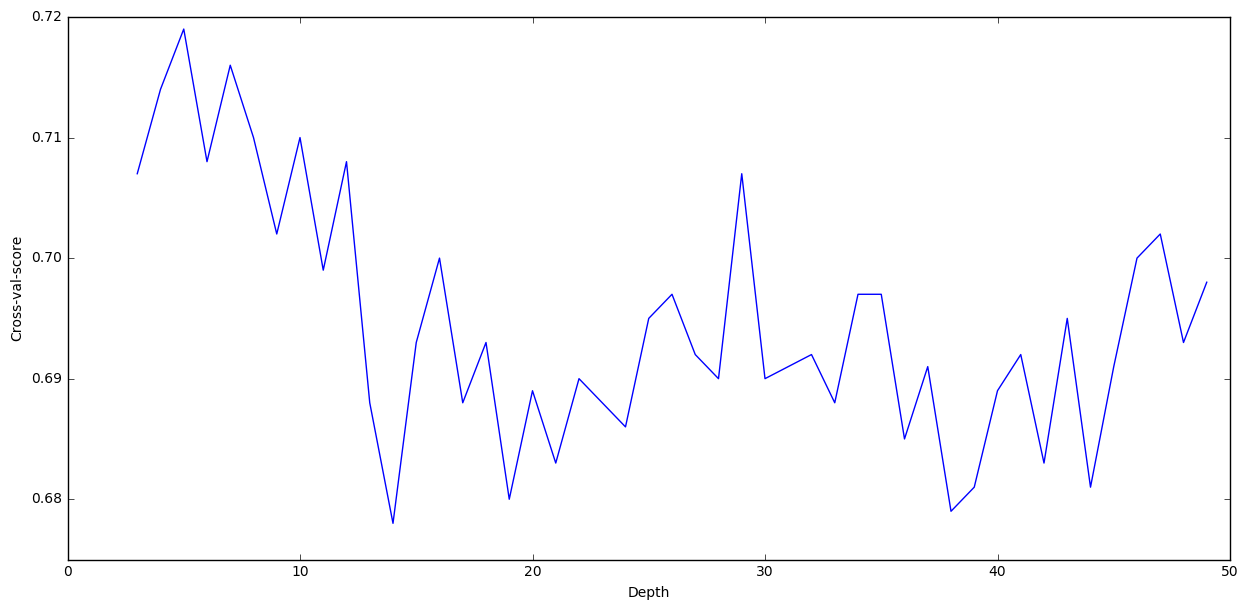

In [18]:
plot_quality(quality_cross_val)

Лучшие результаты показывают небольшие деревья, при глубине больше 10 наблюдаем эффект переобучения.

In [19]:
def quality_train(max_depth):
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X, y)
    return sklearn.metrics.accuracy_score(y, clf.predict(X))

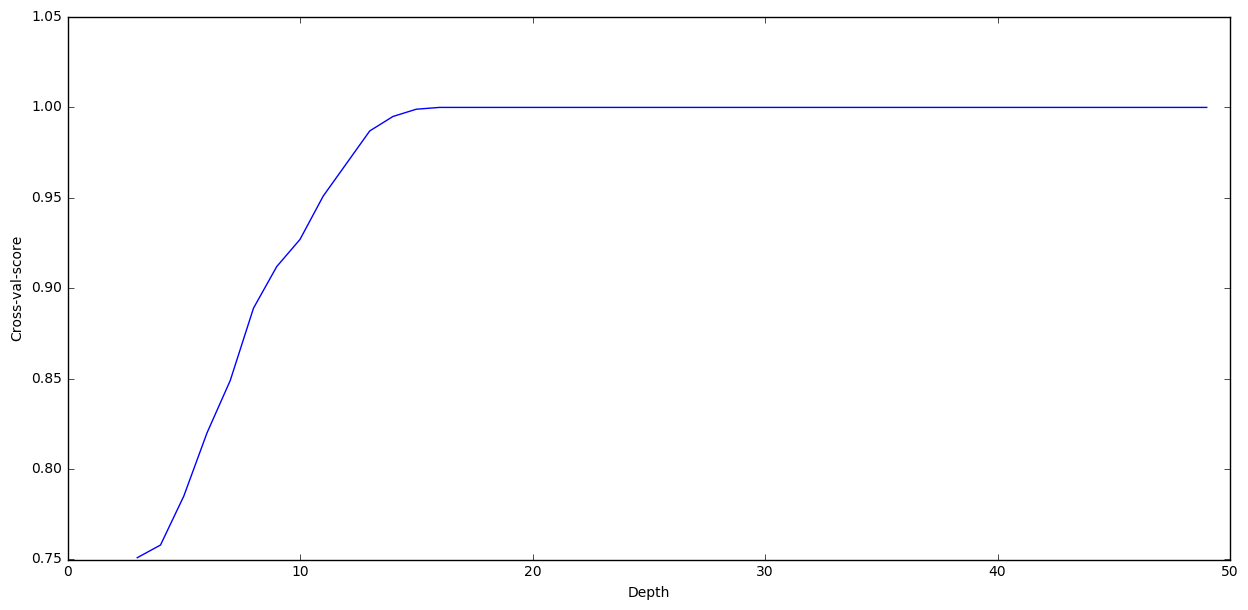

In [20]:
plot_quality(quality_train)

А на обучающей выборке начиная с глубины около 12 дерево идеально предсказывает ответ, что подтверждает предположение о переобучении.

# Реализация решающего дерева

In [31]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf):
        if (max_depth):
            self.max_depth = max_depth
        else:
            self.max_depth = np.inf
        
    class Split():
        def __init__(self, depth, max_depth, X, y):
            self.depth = depth
            self.max_depth = max_depth
            self.X = X
            self.y = y
            self.ans = y.mean()
            
            if (self.X.shape[0] > 1) and (self.depth < self.max_depth):
                self.best_split()
                
            else:
                self.feature = "NONE"
                self.border = "NONE"
                self.left = None
                self.right = None

        def best_split(self):
            assert(self.X.shape[0] > 1)

            best_mse = np.inf
            for feature in range(self.X.shape[1]):
                for border in np.linspace(self.X[:,feature].min(),
                                         self.X[:,feature].max(), 2):
                    x_left = self.X[self.X[:,feature] <= border]
                    y_left = self.y[self.X[:,feature] <= border]
                    x_right = self.X[self.X[:,feature] > border]
                    y_right = self.y[self.X[:,feature] > border]
                    
                    mse = 0
                    mse_left = 0
                    mse_right = 0
                    if (y_left.shape[0] > 0):
                        mse_left = np.mean((y_left - y_left.mean())**2)
                    if (y_right.shape[0] > 0):
                        mse_right = np.mean((y_right - y_right.mean())**2)
                    
                    mse = y_left.shape[0] / y.shape[0] * mse_left + \
                        y_right.shape[0] / y.shape[0] * mse_right
                    
                    if (mse < best_mse):
                        best_feature = feature
                        best_border = border
                        best_mse = mse

            assert(best_mse < np.inf)
            self.feature = best_feature
            self.border = best_border
            
            #print("Built a node")

            x_left = self.X[self.X[:,self.feature] <= self.border]
            x_right = self.X[self.X[:,self.feature] > self.border]
            y_left = self.y[self.X[:,self.feature] <= self.border]
            y_right = self.y[self.X[:,self.feature] > self.border]
                
            if (x_left.shape[0] > 0) and (x_right.shape[0] > 0):
                self.left = self.__class__(self.depth + 1, self.max_depth,
                                 x_left, y_left)
                self.right = self.__class__(self.depth + 1, self.max_depth,
                                  x_right, y_right)
            else:
                self.left = None
                self.right = None
        
        def printout(self):
            if (self.left != None):
                print("Yes")
                self.left.printout()
                
            if (self.right != None):
                print("No")
                self.right.printout()
                
                
    def fit(self, x, y):
        self.head = self.Split(0, self.max_depth, x, y)
        
    def printout(self):
        self.head.printout()
        
    def predict(self, X):
        return np.array([self.__predict_simple(x) for x in X])
    
    def __predict_simple(self, x):
        current_node = self.head
        while (current_node.left != None):
            assert(current_node.right != None)
            if x[current_node.feature] <= current_node.border:
                current_node = current_node.left
            else:
                current_node = current_node.right
        
        return current_node.ans

In [32]:
clf = DecisionTree()

In [33]:
boston = sklearn.datasets.load_boston()
x = boston.data
y = boston.target

In [34]:
score_depth_7 = np.abs(sklearn.cross_validation.cross_val_score(DecisionTree(max_depth=7), x, y, cv=5, 
                                                         scoring='mean_squared_error')).mean()

In [35]:
score_depth_7

84.937351791682048

In [28]:
def get_score(max_depth):
    return np.abs(sklearn.cross_validation.cross_val_score(DecisionTree(max_depth=max_depth), x, y, cv=5, 
                                                         scoring='mean_squared_error')).mean()


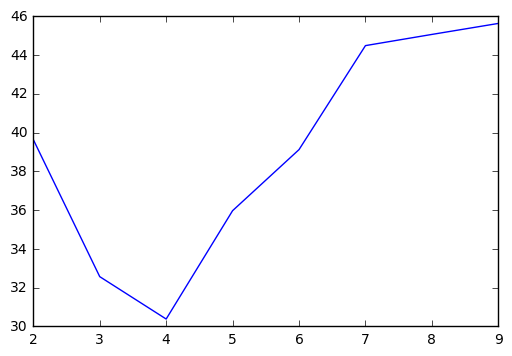

In [30]:
depths = np.arange(2, 10)
scores = np.array([get_score(depth) for depth in depths])

plt.plot(depths, scores)
plt.show()

График можно интерпретировать так: сначала слабое дерево плохо улавливает закономерность, затем на глубине 10-12 достигает наилучшего качества, а потом переобучается